In [1]:
"""
Model Comparison Notebook - Complete Training Pipeline
- Trains all models with hyperparameter tuning
- Saves trained models to disk
- Saves predictions and metrics
- Generates comprehensive plots
"""

from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
import pickle
import json
from datetime import datetime

# Add src to path for local imports
project_root = Path("..").resolve()
src_path = str(project_root / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from neural_decoding.data import load_dataset, bin_spikes, bin_output, prepare_train_test_split
from neural_decoding.evaluation.metrics import evaluate_decoder
from neural_decoding.models import (
    WienerFilterDecoder,
    WienerCascadeDecoder,
    KalmanFilterDecoder,
)

# Import neural net decoders
try:
    from neural_decoding.models.neural_nets import DenseNNDecoder, LSTMDecoder
    print("✓ DenseNNDecoder and LSTMDecoder imported successfully")
    nn_available = True
except ImportError as e:
    print(f"⚠ Neural network models unavailable: {e}")
    DenseNNDecoder = None
    LSTMDecoder = None
    nn_available = False

# Setup plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

print("✓ All imports successful")

2026-01-24 13:11:32.779396: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-24 13:11:32.807434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✓ DenseNNDecoder and LSTMDecoder imported successfully
✓ All imports successful


2026-01-24 13:11:33.411844: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Configuration

In [2]:
# ===== Configuration =====

# Dataset paths
data_dir = project_root / "data" / "raw"
dataset_paths = {
    "M1": data_dir / "m1_data_raw.mat",
    "HC": data_dir / "hc_data_raw.mat",
}

# Binning strategies (per dataset)
binning_config = {
    "M1": {"bin_size": 0.05, "bins_before": 13, "bins_current": 1, "bins_after": 0},
    "HC": {"bin_size": 0.20, "bins_before": 4, "bins_current": 1, "bins_after": 5},
}

# Split params
test_size = 0.2
validation_size = 0.1
random_seed = 42

# Output directories
models_dir = project_root / "reports" / "models"
outputs_dir = project_root / "reports" / "outputs"
figures_dir = project_root / "reports" / "figures"

# Create directories
models_dir.mkdir(parents=True, exist_ok=True)
outputs_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

# Kalman filter optimal parameters (based on prior tuning/theory)
# These are used for one-shot training without tuning
kalman_optimal_params = {
    "M1": {"noise_scale_c": 1.0},  # Conservative default
    "HC": {"noise_scale_c": 1.0},
}

# Define all models
model_names = ["Wiener Filter", "Wiener Cascade", "Kalman Filter"]
if nn_available:
    model_names.extend(["Dense NN", "LSTM"])

dataset_names = list(dataset_paths.keys())

print(f"✓ Configuration loaded")
print(f"  Models: {model_names}")
print(f"  Datasets: {dataset_names}")
print(f"  Output dirs: models={models_dir}, outputs={outputs_dir}, figures={figures_dir}")

✓ Configuration loaded
  Models: ['Wiener Filter', 'Wiener Cascade', 'Kalman Filter', 'Dense NN', 'LSTM']
  Datasets: ['M1', 'HC']
  Output dirs: models=/home/kay/Neural_Decoding_DS_Final/reports/models, outputs=/home/kay/Neural_Decoding_DS_Final/reports/outputs, figures=/home/kay/Neural_Decoding_DS_Final/reports/figures


## Helper Functions

In [6]:
# ===== Helper Functions =====

def get_end_time(spike_times, output_times) -> float:
    """Determine safe end time from spike and output data."""
    max_spike = max((np.max(n) if len(n) > 0 else 0.0 for n in spike_times))
    max_output = float(np.max(output_times)) if output_times.size else 0.0
    return min(max_spike, max_output)


def prepare_data(mat_path: Path, ds_name: str):
    """Load and preprocess a dataset using its binning strategy; return train/valid/test splits."""
    if ds_name not in binning_config:
        raise ValueError(f"No binning configuration found for dataset '{ds_name}'")

    cfg = binning_config[ds_name]
    bin_size = cfg["bin_size"]
    bins_before = cfg["bins_before"]
    bins_after = cfg["bins_after"]
    bins_current = cfg["bins_current"]

    raw = load_dataset(mat_path)
    spike_times = raw["spike_times"]
    outputs = raw["outputs"]
    output_times = raw["output_times"]

    end_time = get_end_time(spike_times, output_times)
    neural = bin_spikes(spike_times, bin_size, start_time=0.0, end_time=end_time)
    outputs_binned = bin_output(outputs, output_times, bin_size, start_time=0.0, end_time=end_time)

    X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_train_test_split(
        neural,
        outputs_binned,
        bins_before,
        bins_after,
        bins_current,
        test_size=test_size,
        validation_size=validation_size,
        random_seed=random_seed,
    )
    return X_train, X_valid, X_test, y_train, y_valid, y_test


def save_model(model, model_name: str, dataset_name: str, params: dict = None):
    """Save model to disk."""
    safe_name = model_name.replace(" ", "_").lower()
    model_path = models_dir / f"{safe_name}_{dataset_name.lower()}.pkl"
    
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    # Save parameters separately
    if params:
        params_path = models_dir / f"{safe_name}_{dataset_name.lower()}_params.json"
        with open(params_path, 'w') as f:
            json.dump(params, f, indent=2)
    
    print(f"      ✓ Model saved to {model_path.name}")
    return model_path


def save_predictions(y_test, y_pred, metrics, model_name: str, dataset_name: str, params: dict = None):
    """Save predictions and metrics to disk."""
    safe_name = model_name.replace(" ", "_").lower()
    output_path = outputs_dir / f"{safe_name}_{dataset_name.lower()}_predictions.npz"
    
    # Convert metrics to saveable format
    metrics_serializable = {}
    for key, val in metrics.items():
        if isinstance(val, np.ndarray):
            metrics_serializable[key] = val.tolist()
        elif isinstance(val, str):
            metrics_serializable[key] = val
        else:
            try:
                metrics_serializable[key] = float(val)
            except (ValueError, TypeError):
                metrics_serializable[key] = str(val)
    
    np.savez(
        output_path,
        y_test=y_test,
        y_pred=y_pred,
        **{f"metric_{k}": v for k, v in metrics_serializable.items()}
    )
    
    # Save metrics as JSON for easy reading
    metrics_path = outputs_dir / f"{safe_name}_{dataset_name.lower()}_metrics.json"
    save_dict = {
        "model": model_name,
        "dataset": dataset_name,
        "metrics": metrics_serializable,
        "params": params or {},
        "timestamp": datetime.now().isoformat()
    }
    with open(metrics_path, 'w') as f:
        json.dump(save_dict, f, indent=2)
    
    print(f"      ✓ Predictions saved to {output_path.name}")
    return output_path

print("✓ Helper functions defined")

✓ Helper functions defined


In [7]:
# ===== Hyperparameter Tuning Functions =====

def tune_wiener_cascade(X_train, y_train, X_valid, y_valid):
    """Tune Wiener Cascade degree parameter."""
    print("      Tuning Wiener Cascade...")
    
    def evaluate(degree):
        d = int(degree)
        model = WienerCascadeDecoder(degree=d)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_valid)
        res = evaluate_decoder(y_valid, y_val_pred)
        return np.mean(res["r2"])

    optimizer = BayesianOptimization(
        f=evaluate,
        pbounds={'degree': (2, 5)},
        random_state=42,
        verbose=0
    )
    optimizer.maximize(init_points=5, n_iter=15)
    
    best_params = {'degree': int(optimizer.max['params']['degree'])}
    return best_params


def tune_dense_nn(X_train, y_train, X_valid, y_valid):
    """Tune Dense NN hyperparameters."""
    print("      Tuning Dense NN...")
    
    def evaluate(units, dropout_rate, num_epochs):
        model = DenseNNDecoder(
            units=int(units),
            dropout_rate=dropout_rate,
            num_epochs=int(num_epochs),
            batch_size=128,
            verbose=0
        )
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_valid)
        res = evaluate_decoder(y_valid, y_val_pred)
        return np.mean(res["r2"])

    optimizer = BayesianOptimization(
        f=evaluate,
        pbounds={
            'units': (64, 256),
            'dropout_rate': (0.05, 0.5),
            'num_epochs': (15, 40)
        },
        random_state=42,
        verbose=0
    )
    optimizer.maximize(init_points=10, n_iter=25)
    
    best_params = {
        'units': int(optimizer.max['params']['units']),
        'dropout_rate': optimizer.max['params']['dropout_rate'],
        'num_epochs': int(optimizer.max['params']['num_epochs'])
    }
    return best_params


def tune_lstm(X_train, y_train, X_valid, y_valid):
    """Tune LSTM hyperparameters."""
    print("      Tuning LSTM...")
    
    def evaluate(units, dropout_rate, num_epochs):
        model = LSTMDecoder(
            units=int(units),
            dropout_rate=dropout_rate,
            num_epochs=int(num_epochs),
            batch_size=128,
            verbose=0
        )
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_valid)
        res = evaluate_decoder(y_valid, y_val_pred)
        return np.mean(res["r2"])

    optimizer = BayesianOptimization(
        f=evaluate,
        pbounds={
            'units': (32, 256),
            'dropout_rate': (0.05, 0.5),
            'num_epochs': (15, 40)
        },
        random_state=42,
        verbose=0
    )
    optimizer.maximize(init_points=10, n_iter=25)
    
    best_params = {
        'units': int(optimizer.max['params']['units']),
        'dropout_rate': optimizer.max['params']['dropout_rate'],
        'num_epochs': int(optimizer.max['params']['num_epochs'])
    }
    return best_params


def get_tuned_params(model_name, dataset_name, X_train, y_train, X_valid, y_valid):
    """Get tuned parameters for a model (or use optimal defaults for Kalman)."""
    
    if model_name == "Wiener Filter":
        # No tuning needed - no hyperparameters
        return {}
    
    elif model_name == "Wiener Cascade":
        return tune_wiener_cascade(X_train, y_train, X_valid, y_valid)
    
    elif model_name == "Kalman Filter":
        # Use optimal parameters without tuning (one-shot training)
        print("      Using optimal Kalman parameters (no tuning)")
        return kalman_optimal_params[dataset_name]
    
    elif model_name == "Dense NN" and nn_available:
        return tune_dense_nn(X_train, y_train, X_valid, y_valid)
    
    elif model_name == "LSTM" and nn_available:
        return tune_lstm(X_train, y_train, X_valid, y_valid)
    
    else:
        return {}


def create_model(model_name, params):
    """Create a model instance with given parameters."""
    
    if model_name == "Wiener Filter":
        return WienerFilterDecoder()
    
    elif model_name == "Wiener Cascade":
        return WienerCascadeDecoder(degree=params.get('degree', 3))
    
    elif model_name == "Kalman Filter":
        return KalmanFilterDecoder(noise_scale_c=params.get('noise_scale_c', 1.0))
    
    elif model_name == "Dense NN" and nn_available:
        return DenseNNDecoder(
            units=params.get('units', 128),
            dropout_rate=params.get('dropout_rate', 0.25),
            num_epochs=params.get('num_epochs', 20),
            batch_size=128,
            verbose=0
        )
    
    elif model_name == "LSTM" and nn_available:
        return LSTMDecoder(
            units=params.get('units', 64),
            dropout_rate=params.get('dropout_rate', 0.25),
            num_epochs=params.get('num_epochs', 20),
            batch_size=128,
            verbose=0
        )
    
    else:
        raise ValueError(f"Unknown model: {model_name}")

print("✓ Tuning functions defined")

✓ Tuning functions defined


## Train All Models on Both Datasets

In [8]:
# ===== MAIN TRAINING LOOP =====

print("=" * 80)
print("TRAINING ALL MODELS WITH TUNING")
print("=" * 80)

# Store all results
results = {ds: {} for ds in dataset_names}
train_means = {}

for ds_name, ds_path in dataset_paths.items():
    print(f"\n{'=' * 80}")
    print(f"DATASET: {ds_name}")
    print(f"{'=' * 80}")
    
    # Load and prepare data
    print(f"  Loading data...")
    X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(ds_path, ds_name)
    train_mean = np.mean(y_train, axis=0)
    train_means[ds_name] = train_mean
    
    print(f"  ✓ Data loaded: X_train={X_train.shape}, X_valid={X_valid.shape}, X_test={X_test.shape}")
    
    # Train each model
    for model_name in model_names:
        print(f"\n  [{model_name}]")
        
        # 1. Get tuned parameters (or optimal defaults for Kalman)
        best_params = get_tuned_params(model_name, ds_name, X_train, y_train, X_valid, y_valid)
        
        if best_params:
            print(f"      ✓ Parameters: {best_params}")
        
        # 2. Create and train final model on full training set
        print(f"      Training final model...")
        model = create_model(model_name, best_params)
        model.fit(X_train, y_train)
        
        # 3. Predict on test set
        y_pred = model.predict(X_test)
        
        # 4. Evaluate
        metrics = evaluate_decoder(y_test, y_pred, decoder_name=model_name)
        mean_r2 = float(np.mean(np.atleast_1d(metrics["r2"])))
        
        print(f"      ✓ Test R² = {mean_r2:.4f}")
        
        # 5. Save model and predictions
        save_model(model, model_name, ds_name, best_params)
        save_predictions(y_test, y_pred, metrics, model_name, ds_name, best_params)
        
        # 6. Store results for plotting
        results[ds_name][model_name] = {
            "y_test": y_test,
            "y_pred": y_pred,
            "metrics": metrics,
            "params": best_params,
            "model": model
        }
    
    # Store train mean for later use
    results[ds_name]["_train_mean"] = train_mean

print(f"\n{'=' * 80}")
print("✓ ALL MODELS TRAINED AND SAVED")
print(f"{'=' * 80}")

TRAINING ALL MODELS WITH TUNING

DATASET: M1
  Loading data...
  ✓ Data loaded: X_train=(17711, 2296), X_valid=(2529, 2296), X_test=(5059, 2296)

  [Wiener Filter]
      Training final model...
      ✓ Test R² = 0.7890
      ✓ Model saved to wiener_filter_m1.pkl
      ✓ Predictions saved to wiener_filter_m1_predictions.npz

  [Wiener Cascade]
      Tuning Wiener Cascade...
      ✓ Parameters: {'degree': 5}
      Training final model...
      ✓ Test R² = 0.8008
      ✓ Model saved to wiener_cascade_m1.pkl
      ✓ Predictions saved to wiener_cascade_m1_predictions.npz

  [Kalman Filter]
      Using optimal Kalman parameters (no tuning)
      ✓ Parameters: {'noise_scale_c': 1.0}
      Training final model...


2026-01-24 13:25:44,093 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0


      ✓ Test R² = 0.7868
      ✓ Model saved to kalman_filter_m1.pkl
      ✓ Predictions saved to kalman_filter_m1_predictions.npz

  [Dense NN]
      Tuning Dense NN...


I0000 00:00:1769261144.204351 3628744 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22052 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2026-01-24 13:25:44.967675: I external/local_xla/xla/service/service.cc:163] XLA service 0x709944017790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-24 13:25:44.967688: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2026-01-24 13:25:44.979358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-24 13:25:45.047811: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-01-24 13:25:45.098747: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs we

      ✓ Parameters: {'units': 199, 'dropout_rate': np.float64(0.05), 'num_epochs': 39}
      Training final model...


2026-01-24 13:30:40.627012: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_23', 4 bytes spill stores, 4 bytes spill loads

2026-01-24 13:30:40,815 - attrs.py - create - DEBUG - Creating converter from 5 to 3
2026-01-24 13:30:40,837 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0


      ✓ Test R² = 0.8890
      ✓ Model saved to dense_nn_m1.pkl
      ✓ Predictions saved to dense_nn_m1_predictions.npz

  [LSTM]
      Tuning LSTM...


2026-01-24 13:31:00,336 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:31:12,326 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:31:29,604 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:31:51,760 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:32:05,285 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:32:23,167 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:32:39,404 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:32:52,660 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:33:02,569 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:33:13,204 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_dev

      ✓ Parameters: {'units': 256, 'dropout_rate': np.float64(0.32196748672472125), 'num_epochs': 40}
      Training final model...
      ✓ Test R² = 0.9068
      ✓ Model saved to lstm_m1.pkl
      ✓ Predictions saved to lstm_m1_predictions.npz

DATASET: HC
  Loading data...
  ✓ Data loaded: X_train=(19499, 580), X_valid=(2785, 580), X_test=(5570, 580)

  [Wiener Filter]
      Training final model...
      ✓ Test R² = 0.4024
      ✓ Model saved to wiener_filter_hc.pkl
      ✓ Predictions saved to wiener_filter_hc_predictions.npz

  [Wiener Cascade]
      Tuning Wiener Cascade...
      ✓ Parameters: {'degree': 4}
      Training final model...
      ✓ Test R² = 0.4260
      ✓ Model saved to wiener_cascade_hc.pkl
      ✓ Predictions saved to wiener_cascade_hc_predictions.npz

  [Kalman Filter]
      Using optimal Kalman parameters (no tuning)
      ✓ Parameters: {'noise_scale_c': 1.0}
      Training final model...


2026-01-24 13:41:40,771 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0


      ✓ Test R² = 0.2606
      ✓ Model saved to kalman_filter_hc.pkl
      ✓ Predictions saved to kalman_filter_hc_predictions.npz

  [Dense NN]
      Tuning Dense NN...


2026-01-24 13:41:41.243873: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-24 13:41:41.499916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1039', 72 bytes spill stores, 72 bytes spill loads

2026-01-24 13:41:41.739765: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1039', 48 bytes spill stores, 48 bytes spill loads

2026-01-24 13:41:41.751423: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1039', 8 byt

      ✓ Parameters: {'units': 199, 'dropout_rate': np.float64(0.05), 'num_epochs': 39}
      Training final model...


2026-01-24 13:46:23,817 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0


      ✓ Test R² = 0.6382
      ✓ Model saved to dense_nn_hc.pkl
      ✓ Predictions saved to dense_nn_hc_predictions.npz

  [LSTM]
      Tuning LSTM...


2026-01-24 13:46:47,383 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:46:56,166 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:47:15,482 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:47:38,469 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:47:44,869 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:47:58,415 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:48:19,396 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:48:32,507 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:48:44,374 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_device:GPU:0
2026-01-24 13:48:54,744 - neural_nets.py - _choose_device - INFO - Using GPU: /physical_dev

      ✓ Parameters: {'units': 239, 'dropout_rate': np.float64(0.05), 'num_epochs': 40}
      Training final model...
      ✓ Test R² = 0.2191
      ✓ Model saved to lstm_hc.pkl
      ✓ Predictions saved to lstm_hc_predictions.npz

✓ ALL MODELS TRAINED AND SAVED


## Visualization: Model Predictions

Compare true vs predicted outputs for all models across both datasets.

In [9]:
# ===== Plotting Functions =====

def smooth_series(arr: np.ndarray, window: int) -> np.ndarray:
    """Apply moving average smoothing for visualization."""
    if window <= 1:
        return arr
    window = int(window)
    padded = np.pad(arr, (window // 2,), mode="edge")
    kernel = np.ones(window) / window
    smoothed = np.convolve(padded, kernel, mode="valid")
    return smoothed[:len(arr)]


def plot_model_grid(results, binning_config, train_means, output_dim=0, smooth_window=7, 
                     plot_windows=None, save_path=None):
    """Create grid of plots: models (rows) × datasets (columns)."""
    
    if plot_windows is None:
        plot_windows = {
            "HC": (2000, 5000),  # Show 3000 time points
            "M1": (1000, 2000),  # Show 1000 time points
        }
    
    model_names = [k for k in results[list(results.keys())[0]].keys() if k != "_train_mean"]
    dataset_names = list(results.keys())
    
    n_models = len(model_names)
    n_datasets = len(dataset_names)
    
    # Create color map for models
    colors = sns.color_palette("husl", n_colors=n_models)
    color_map = dict(zip(model_names, colors))
    
    # Create figure
    fig, axes = plt.subplots(
        n_models, n_datasets,
        figsize=(6 * n_datasets, 3.5 * n_models),
        sharex=False, sharey=False
    )
    
    # Handle single row/column cases
    if n_models == 1 and n_datasets == 1:
        axes = np.array([[axes]])
    elif n_models == 1:
        axes = axes.reshape(1, -1)
    elif n_datasets == 1:
        axes = axes.reshape(-1, 1)
    
    for row_idx, model_name in enumerate(model_names):
        for col_idx, ds_name in enumerate(dataset_names):
            ax = axes[row_idx, col_idx]
            
            res = results[ds_name][model_name]
            bin_size = binning_config[ds_name]["bin_size"]
            
            # Get window range
            start, end = plot_windows.get(ds_name, (0, len(res["y_test"])))
            start = min(start, len(res["y_test"]))
            end = min(end, len(res["y_test"]))
            
            # Extract data for plotting
            y_true_full = res["y_test"][:, output_dim]
            y_pred_full = res["y_pred"][:, output_dim]
            train_mean = train_means[ds_name]
            base = float(train_mean[output_dim]) if train_mean.size > output_dim else 0.0
            
            # Apply window and restore mean
            y_true = y_true_full[start:end] + base
            y_pred = y_pred_full[start:end] + base
            
            # Smooth for visualization
            y_true_s = smooth_series(y_true, smooth_window)
            y_pred_s = smooth_series(y_pred, smooth_window)
            
            # Time axis
            time_axis = np.arange(len(y_true)) * bin_size
            
            # Plot
            ax.plot(time_axis, y_true_s, color="black", linewidth=1.8, 
                   label="True", alpha=0.9)
            ax.plot(time_axis, y_pred_s, color=color_map[model_name], 
                   linewidth=1.4, alpha=0.9, label="Predicted")
            
            # Get R² for this dimension
            r2_val = float(np.atleast_1d(res["metrics"]["r2"])[output_dim])
            
            # Labels and styling
            if row_idx == 0:
                window_desc = f"t={start}:{end} (bin={bin_size:.2g}s)"
                ax.set_title(f"{ds_name}\n{window_desc}", fontsize=12, fontweight="bold")
            
            ax.set_ylabel(f"{model_name}\nR²={r2_val:.3f}", fontsize=10)
            
            if row_idx == n_models - 1:
                ax.set_xlabel("Time (s)", fontsize=10)
            
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.grid(True, alpha=0.3)
            
            if row_idx == 0 and col_idx == n_datasets - 1:
                ax.legend(loc="upper right", fontsize=9)
    
    fig.suptitle("Model Comparison: True vs Predicted Outputs", 
                 fontsize=15, fontweight="bold", y=0.995)
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"✓ Figure saved to {save_path}")
    
    return fig

print("✓ Plotting functions defined")

✓ Plotting functions defined


## Performance Bar Chart

2026-01-24 14:18:34,531 - pyplot.py - switch_backend - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2026-01-24 14:18:34,536 - pyplot.py - switch_backend - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2026-01-24 14:18:34,542 - font_manager.py - _findfont_cached - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2026-01-24 14:18:34,544 - font_manager.py - _findfont_cached - DEBUG - findfont: score(FontEntry(fname='/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2026-01-24 14:18:34,545 - font_manager.py - _findfont_cached - DEBUG - findfont: score(FontEntry(fname='/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi1

✓ Bar chart saved to /home/kay/Neural_Decoding_DS_Final/reports/figures/performance_comparison_bars.png


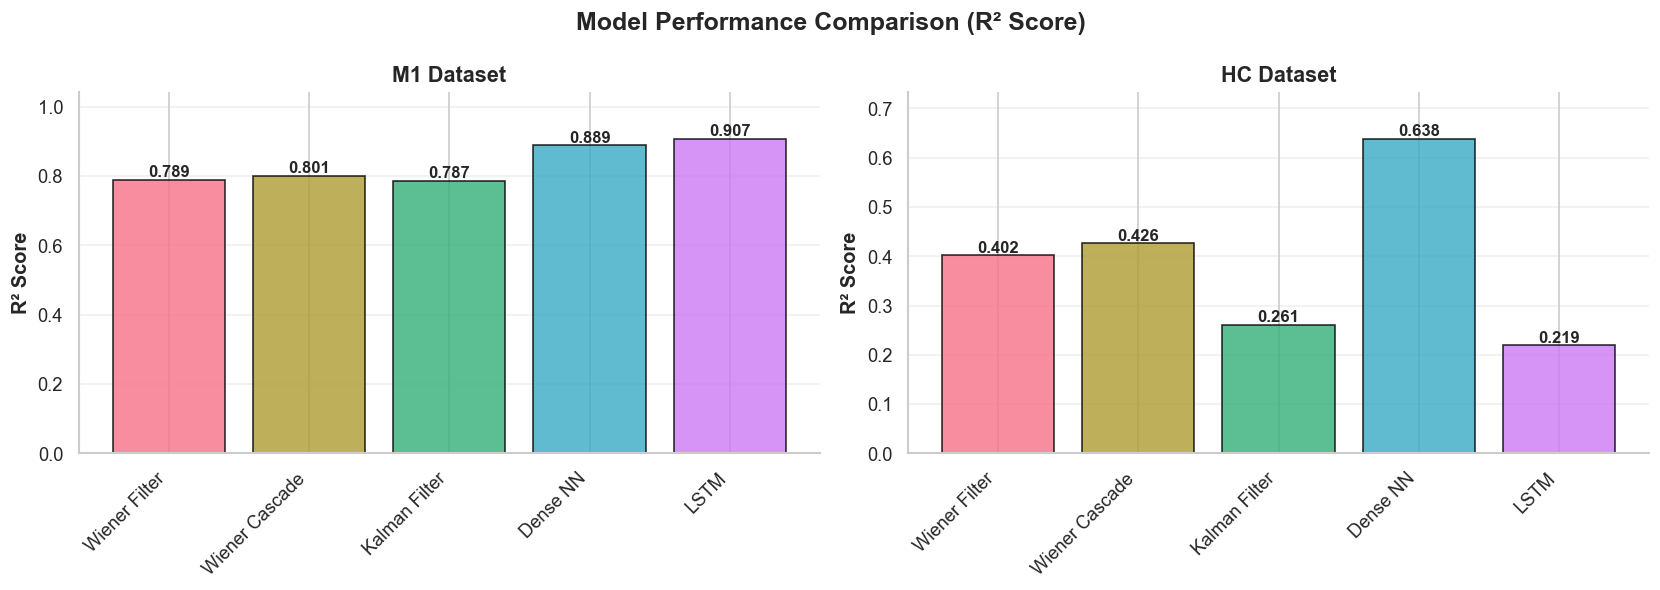

In [10]:
# ===== Bar Chart: R² Comparison =====

import pandas as pd

# Prepare data for bar chart
model_names_list = [k for k in results[list(results.keys())[0]].keys() if k != "_train_mean"]
dataset_names_list = list(results.keys())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, ds_name in enumerate(dataset_names_list):
    ax = axes[idx]
    
    models = []
    r2_scores = []
    
    for model_name in model_names_list:
        res = results[ds_name][model_name]
        r2 = np.mean(np.atleast_1d(res["metrics"]["r2"]))
        models.append(model_name)
        r2_scores.append(r2)
    
    # Create bar chart
    colors = sns.color_palette("husl", n_colors=len(models))
    bars = ax.bar(range(len(models)), r2_scores, color=colors, alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, r2_scores)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{ds_name} Dataset', fontsize=13, fontweight='bold')
    ax.set_ylim(0, max(r2_scores) * 1.15)
    ax.grid(axis='y', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.suptitle('Model Performance Comparison (R² Score)', fontsize=15, fontweight='bold')
plt.tight_layout()

# Save figure
bar_chart_path = figures_dir / "performance_comparison_bars.png"
fig.savefig(bar_chart_path, dpi=150, bbox_inches='tight')
print(f"✓ Bar chart saved to {bar_chart_path}")

plt.show()

2026-01-24 14:18:42,562 - font_manager.py - _findfont_cached - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2026-01-24 14:18:42,562 - font_manager.py - _findfont_cached - DEBUG - findfont: score(FontEntry(fname='/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2026-01-24 14:18:42,563 - font_manager.py - _findfont_cached - DEBUG - findfont: score(FontEntry(fname='/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2026-01-24 14:18:42,563 - font_manager.py - _findfont_cached - DEBUG - findfont: score(FontEntry(fname='/home/kay/miniconda3/envs/fast_shap/lib/python3.10/site-packages/matplotlib/

✓ Figure saved to /home/kay/Neural_Decoding_DS_Final/reports/figures/model_comparison_grid.png


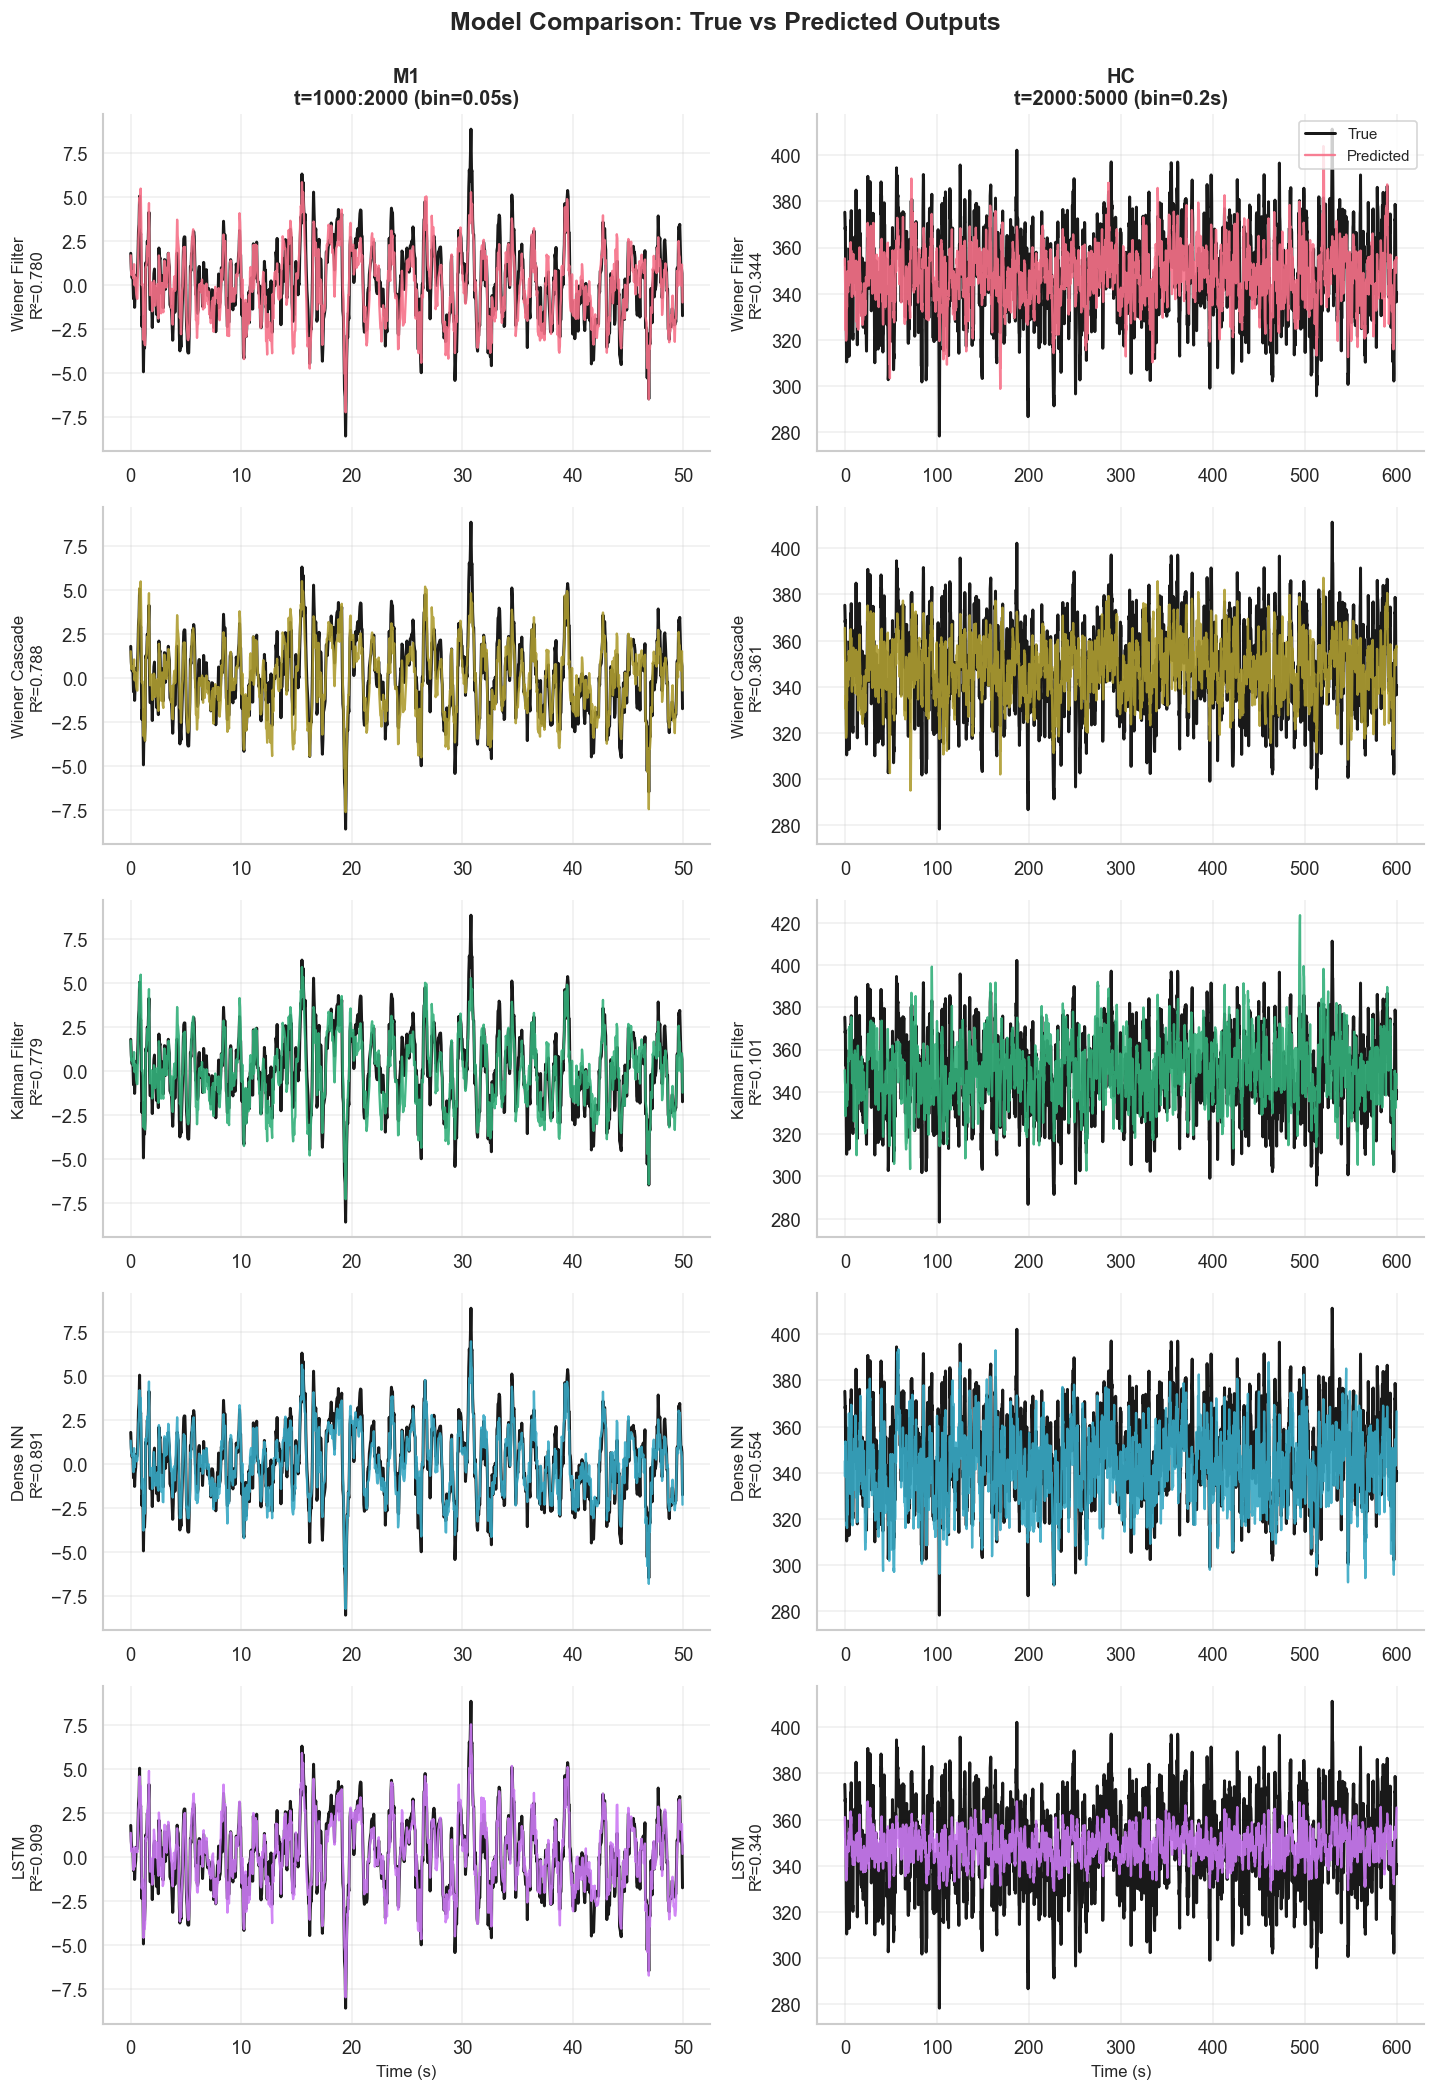

In [11]:
# ===== Generate Main Prediction Grid Plot =====

fig = plot_model_grid(
    results=results,
    binning_config=binning_config,
    train_means=train_means,
    output_dim=0,
    smooth_window=7,
    plot_windows={"HC": (2000, 5000), "M1": (1000, 2000)},
    save_path=figures_dir / "model_comparison_grid.png"
)

plt.show()

## Summary Table: All Results

In [12]:
# ===== Summary Table =====

import pandas as pd

model_names_list = [k for k in results[list(results.keys())[0]].keys() if k != "_train_mean"]
dataset_names_list = list(results.keys())

summary_rows = []

for ds_name in dataset_names_list:
    for model_name in model_names_list:
        res = results[ds_name][model_name]
        metrics = res["metrics"]
        params = res["params"]
        
        r2 = float(np.mean(np.atleast_1d(metrics["r2"])))
        rho = float(np.mean(np.atleast_1d(metrics["pearson_correlation"])))
        rmse = float(np.mean(np.atleast_1d(metrics["rmse"])))
        
        # Format parameters as string
        param_str = ", ".join([f"{k}={v}" for k, v in params.items()]) if params else "default"
        
        summary_rows.append({
            "Dataset": ds_name,
            "Model": model_name,
            "R²": r2,
            "Correlation": rho,
            "RMSE": rmse,
            "Parameters": param_str
        })

summary_df = pd.DataFrame(summary_rows)

# Display with nice formatting
print("\n" + "=" * 100)
print("SUMMARY OF ALL MODEL RESULTS")
print("=" * 100 + "\n")

display(summary_df.style.format({
    "R²": "{:.4f}",
    "Correlation": "{:.4f}",
    "RMSE": "{:.4f}"
}).background_gradient(subset=['R²'], cmap='RdYlGn'))

# Save to CSV
summary_path = outputs_dir / "model_comparison_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\n✓ Summary table saved to {summary_path}")


SUMMARY OF ALL MODEL RESULTS



,Dataset,Model,R²,Correlation,RMSE,Parameters
0,M1,Wiener Filter,0.7890,0.8889,2.7021,default
1,M1,Wiener Cascade,0.8008,0.8953,2.6246,degree=5
2,M1,Kalman Filter,0.7868,0.8876,2.7163,noise_scale_c=1.0
3,M1,Dense NN,0.8890,0.9439,1.9602,"units=199, dropout_rate=0.05, num_epochs=39"
4,M1,LSTM,0.9068,0.9526,1.7962,"units=256, dropout_rate=0.32196748672472125, num_epochs=40"
5,HC,Wiener Filter,0.4024,0.6344,38.1570,default
6,HC,Wiener Cascade,0.4260,0.6522,37.3882,degree=4
7,HC,Kalman Filter,0.2606,0.5355,42.3081,noise_scale_c=1.0
8,HC,Dense NN,0.6382,0.8079,29.5743,"units=199, dropout_rate=0.05, num_epochs=39"
9,HC,LSTM,0.2191,0.5623,43.3980,"units=239, dropout_rate=0.05, num_epochs=40"



✓ Summary table saved to /home/kay/Neural_Decoding_DS_Final/reports/outputs/model_comparison_summary.csv


## Scatter Plots: True vs Predicted

✓ Scatter plots saved to /home/kay/Neural_Decoding_DS_Final/reports/figures/scatter_plots.png


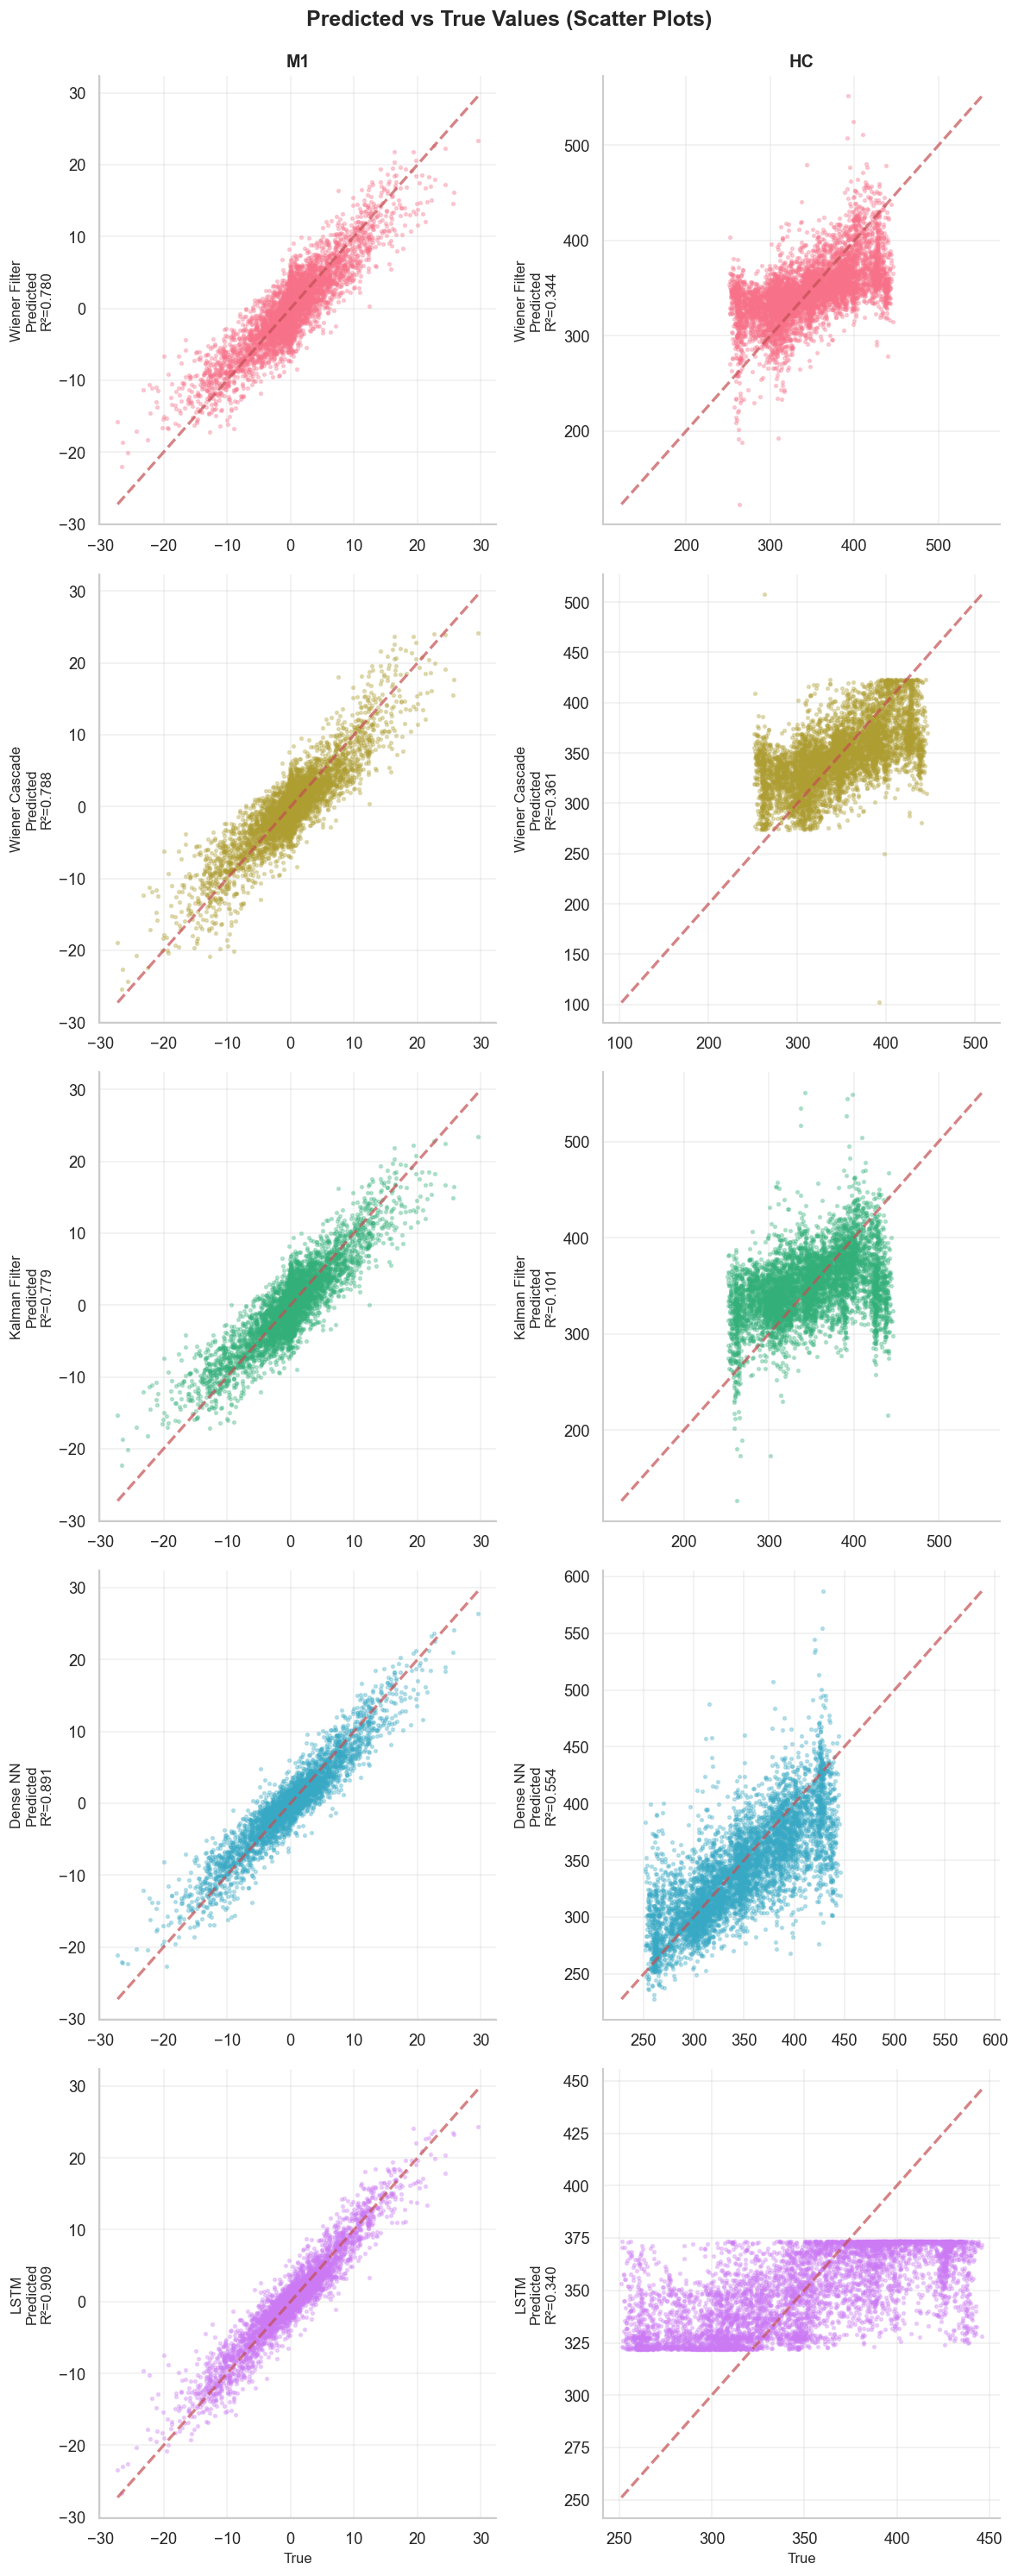

In [13]:
# ===== Scatter Plots: Predicted vs True =====

output_dim = 0  # First output dimension

model_names_list = [k for k in results[list(results.keys())[0]].keys() if k != "_train_mean"]
dataset_names_list = list(results.keys())

n_models = len(model_names_list)
n_datasets = len(dataset_names_list)

fig, axes = plt.subplots(n_models, n_datasets, 
                         figsize=(5 * n_datasets, 5 * n_models),
                         sharex=False, sharey=False)

# Handle single row/column cases
if n_models == 1 and n_datasets == 1:
    axes = np.array([[axes]])
elif n_models == 1:
    axes = axes.reshape(1, -1)
elif n_datasets == 1:
    axes = axes.reshape(-1, 1)

colors = sns.color_palette("husl", n_colors=n_models)
color_map = dict(zip(model_names_list, colors))

for row_idx, model_name in enumerate(model_names_list):
    for col_idx, ds_name in enumerate(dataset_names_list):
        ax = axes[row_idx, col_idx]
        
        res = results[ds_name][model_name]
        
        # Get data
        y_true = res["y_test"][:, output_dim]
        y_pred = res["y_pred"][:, output_dim]
        
        # Restore mean
        train_mean = train_means[ds_name]
        base = float(train_mean[output_dim]) if train_mean.size > output_dim else 0.0
        y_true_restored = y_true + base
        y_pred_restored = y_pred + base
        
        # Scatter plot
        ax.scatter(y_true_restored, y_pred_restored, 
                  alpha=0.3, s=5, color=color_map[model_name])
        
        # Perfect prediction line
        min_val = min(y_true_restored.min(), y_pred_restored.min())
        max_val = max(y_true_restored.max(), y_pred_restored.max())
        ax.plot([min_val, max_val], [min_val, max_val], 
               'r--', linewidth=2, alpha=0.7, label='Perfect')
        
        # R² value
        r2_val = float(np.atleast_1d(res["metrics"]["r2"])[output_dim])
        
        # Labels
        if row_idx == 0:
            ax.set_title(f"{ds_name}", fontsize=12, fontweight='bold')
        
        ax.set_ylabel(f"{model_name}\nPredicted\nR²={r2_val:.3f}", fontsize=10)
        
        if row_idx == n_models - 1:
            ax.set_xlabel("True", fontsize=10)
        
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.suptitle("Predicted vs True Values (Scatter Plots)", 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()

# Save
scatter_path = figures_dir / "scatter_plots.png"
fig.savefig(scatter_path, dpi=150, bbox_inches='tight')
print(f"✓ Scatter plots saved to {scatter_path}")

plt.show()

In [14]:
# ===== FINAL SUMMARY =====

print("=" * 80)
print("TRAINING COMPLETE - SUMMARY")
print("=" * 80)
print()

# Count models and datasets
n_models = len([k for k in results[list(results.keys())[0]].keys() if k != "_train_mean"])
n_datasets = len(results.keys())
total_trained = n_models * n_datasets

print(f"✓ Total models trained: {total_trained}")
print(f"  - {n_models} model types")
print(f"  - {n_datasets} datasets")
print()

# List saved outputs
print("📁 Saved Outputs:")
print(f"  - Models: {models_dir}")
print(f"    Files: {len(list(models_dir.glob('*.pkl')))} model files")
print(f"  - Predictions: {outputs_dir}")
print(f"    Files: {len(list(outputs_dir.glob('*.npz')))} prediction files")
print(f"  - Figures: {figures_dir}")
print(f"    Files: {len(list(figures_dir.glob('*.png')))} figure files")
print()

# Best model per dataset
print("🏆 Best Models (by R²):")
for ds_name in results.keys():
    best_model = None
    best_r2 = -np.inf
    
    for model_name in results[ds_name].keys():
        if model_name == "_train_mean":
            continue
        r2 = np.mean(np.atleast_1d(results[ds_name][model_name]["metrics"]["r2"]))
        if r2 > best_r2:
            best_r2 = r2
            best_model = model_name
    
    print(f"  {ds_name}: {best_model} (R² = {best_r2:.4f})")

print()
print("=" * 80)
print("All results are saved and ready for analysis!")
print("=" * 80)

TRAINING COMPLETE - SUMMARY

✓ Total models trained: 10
  - 5 model types
  - 2 datasets

📁 Saved Outputs:
  - Models: /home/kay/Neural_Decoding_DS_Final/reports/models
    Files: 10 model files
  - Predictions: /home/kay/Neural_Decoding_DS_Final/reports/outputs
    Files: 10 prediction files
  - Figures: /home/kay/Neural_Decoding_DS_Final/reports/figures
    Files: 9 figure files

🏆 Best Models (by R²):
  M1: LSTM (R² = 0.9068)
  HC: Dense NN (R² = 0.6382)

All results are saved and ready for analysis!


## Summary

All models trained with tuning and saved successfully.